# 3D elastic VTI wave equation implementation on a staggered grid

This is a first attempt at implementing the elastic wave equations in 3D vertical transversely isotropic (VTI) media as described in [1].

The notebook implements various Finite Difference schemes to solve this PDE and recreate the results from various forward simulations.

<br> Chirayu Khimji 
<br> Independent Research Project 
<br> MSc Applied Computational Science and Engineering - Imperial College London 
<br> IRP Supervisors: Dr. Gerard Gorman, Dr. Rhodri Nelson and the Devito Project Research Group

## Introduction

To be added in proper academic syntax

## Outline
this cell needs to be completed in more detail when tasks below are completed

1. Scalar PDE Implementation for 3D elastic VTI wave propagation using temporal high-accuracy staggered-grid finite-difference scheme

2. Vectorial PDE Implementation for 3D elastic VTI wave propagation (Vectorized Approach) using temporal high-accuracy staggered-grid finite-difference scheme

3. Implementation Testing: Comparing the results of these two implementations against an pure Elastic Isotropic Implementation

4. Accuracy Testing: 

# Scalar PDE Implementation: 3D Elastic VTI wave-equations
The paper [1] expresses the elastic wave equations as a set of scalar PDEs in conventional velocity-stress format: 

$$
\begin{aligned}
\frac{\partial v_x}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z} \right) \\
\frac{\partial v_y}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z} \right) \\
\frac{\partial v_z}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{yz}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z} \right) \\
\frac{\partial \tau_{xx}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} - 2c_{66}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{yy}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} - 2c_{66}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{13}\frac{\partial v_{x}}{\partial x} + c_{13}\frac{\partial v_{y}}{\partial y} + c_{33}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial x} + c_{44}\frac{\partial v_{x}}{\partial z} \\
\frac{\partial \tau_{yz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial y} + c_{44}\frac{\partial v_{y}}{\partial z} \\
\frac{\partial \tau_{xy}}{\partial t} &= c_{66}\frac{\partial v_{y}}{\partial x} + c_{66}\frac{\partial v_{x}}{\partial y} \\
\end{aligned}
$$

Stiffness coefficients in elastic VTI media can be given by (Thomsen 1986):

$
\begin{aligned}
c_{11} &= \rho \left(1 + 2\epsilon\right)v_{p0}^{2} \\
c_{33} &= \rho v_{p0}^{2} \\
c_{44} &= \rho v_{s0}^{2} \\
c_{66} &= \rho \left(1 + 2\gamma\right)v_{s0}^{2} \\
c_{13} &= \rho v_{p0}^{2}\sqrt{f\left(f + 2\delta\right)} - \rho v_{s0}^{2} \\
f &= 1 - v_{s0}^{2}/v_{p0}^{2} \\
\end{aligned}
$




### Imports
For consistency, all required imports used by this notebook are below:

In [1]:
# Required imports:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic import plot_velocity, RickerSource, TimeAxis, Receiver
from model_VTI import ModelElasticVTI

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

%matplotlib inline

plt.rc('font', size=14)

# default language set to openmp i.e. Code Generated by Devito will be in openmp
#configuration['language'] = 'openmp'

# logging set to debug to capture statistics on the performance of operators
configuration['log-level'] = 'DEBUG'


### Instantiate Devito grid for a three dimensional problem
For initial implementation testing, grid setup equivalent to devito/examples/seismic/tutorials/06_elastic.ipynb

In [2]:
# define precision type: 32bit floating point
dtype = np.float32

# Define dimensions for the interior of the model 
nx, ny, nz = 201, 201, 201          # Number of grid points
dx, dy, dz = 7.5, 7.5, 7.5          # Grid spacing in m
shape = (nx, ny, nz)                # Domain shape 
spacing = (dx, dy, dz)              # Domain size is now 5 km by 5 km
origin = (0., 0., 0.)               # Origin of coordinate system, specified in m.
extent = tuple([i*(n-1) for i, n in zip(spacing, shape)])

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = 0.10
gamma = 0.05

#epsilon = 0
#delta = 0
#gamma = 0

#initial conditions
npad = 20
vp = 2.0 #km/s
vs = 1.0 #km/s
rho= 1.8 #kg/m**3

so = 2 #spatial order
to = 1 #temporal order

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=vp, vs=vs, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl = npad, dtype = dtype, bcs = "mask")

print("")
print("grid.shape:       ", model.grid.shape)
print("grid.origin:      ", origin)
print("grid.spacing_map: ", model.grid.spacing_map)
print("grid.extent:      ", model.grid.extent)


Operator `initdamp` generated in 0.19 s
  * lowering.Clusters: 0.08 s (43.6 %)
     * specializing.Clusters: 0.05 s (27.3 %)
  * lowering.Expressions: 0.06 s (32.7 %)
  * lowering.IET: 0.05 s (27.3 %)
Flops reduction after symbolic optimization: [102 --> 102]
Allocating memory for damp(243, 243, 243)
Operator `initdamp` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/0bcb56a0db272cf73bab141a0872bf676c27504b.c` in 0.07 s from jit-cache
Operator `initdamp` run in 0.07 s
* section0<<20,241,241>,<20,241,241>,<241,20,241>,<241,20,241>,<241,241,20>,<241,241,20>> with OI=0.01 computed in 0.07 s [1.86 GFlops/s]
Performance[mode=advanced] arguments: {}

grid.shape:        (241, 241, 241)
grid.origin:       (0.0, 0.0, 0.0)
grid.spacing_map:  {h_x: 7.5, h_y: 7.5, h_z: 7.5}
grid.extent:       (1800.0, 1800.0, 1800.0)


### Devito's Symbolic Objects are now defined on the `grid` 
The symbolic objects `Function`, `VectorTimeFunction` and `TensorTimeFunction` define the physics of Wavefields onto the grid. These objects account for both spatially varying and time dependent features of Wavefields.

In [3]:
# PDE functions assigned to model:
x, y, z = model.grid.dimensions
# dampening function assigned to model:
damp = model.damp

# Now we create the velocity and pressure fields

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic definition of the model grid spacing for a staggered grid
ts = model.grid.stepping_dim.spacing 

### Define the simulation time range

In [4]:
t0 = 0.     # Simulation time start
tn = 300.  # Simulation time end (1 second = 1000 msec)

dt = model.critical_dt #time step computed from elastic VTI CFL condition

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time range: ", time_range)

Time range:  TimeAxis: start=0, stop=300.312, step=1.164, num=259


### Setting up the acquisition geometry: locations of explosive source and recievers

For an example simulation:
A 10 Hz center frequency Ricker wavelet source, located at (x, y, z) = (750m, 750m, 750m) and is added into $v_x$ component to generate vibration.

For Ricker wavelet, the source signature $g(t)$ is the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Allocating memory for src(259, 1)
Allocating memory for src_coords(1, 3)
Allocating memory for rec_coords(201, 3)
src_coords [x,y,z]: [[750. 750. 750.]]
rec_coords [x,y,z]: [[ 750.     5.     0. ]
 [ 750.     5.     7.5]
 [ 750.     5.    15. ]
 [ 750.     5.    22.5]
 [ 750.     5.    30. ]
 [ 750.     5.    37.5]
 [ 750.     5.    45. ]
 [ 750.     5.    52.5]
 [ 750.     5.    60. ]
 [ 750.     5.    67.5]
 [ 750.     5.    75. ]
 [ 750.     5.    82.5]
 [ 750.     5.    90. ]
 [ 750.     5.    97.5]
 [ 750.     5.   105. ]
 [ 750.     5.   112.5]
 [ 750.     5.   120. ]
 [ 750.     5.   127.5]
 [ 750.     5.   135. ]
 [ 750.     5.   142.5]
 [ 750.     5.   150. ]
 [ 750.     5.   157.5]
 [ 750.     5.   165. ]
 [ 750.     5.   172.5]
 [ 750.     5.   180. ]
 [ 750.     5.   187.5]
 [ 750.     5.   195. ]
 [ 750.     5.   202.5]
 [ 750.     5.   210. ]
 [ 750.     5.   217.5]
 [ 750.     5.   225. ]
 [ 750.     5.   232.5]
 [ 750.     5.   240. ]
 [ 750.     5.   247.5]
 [ 750.    

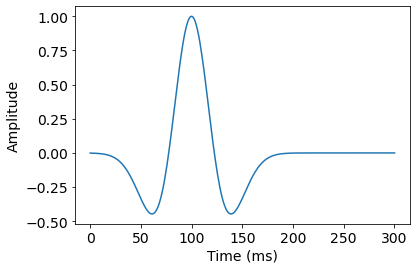

In [5]:
from examples.seismic import AcquisitionGeometry

# Centered Source with 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=model.grid, f0=fpeak, time_range=time_range)
src.coordinates.data[:] = np.array([750., 750., 750.])

rec = Receiver(name='rec', grid=model.grid, npoint = shape[0], time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx/2)
rec.coordinates.data[:,1] = 6
rec.coordinates.data[:,2] = np.linspace(0.0, dz*(nz-1), nz)




### Extra code for different src-recgeometry
# Source and reciver coordinates 
#src_coords = np.empty((1, 3), dtype=dtype)
#rec_coords = np.empty((1, 3), dtype=dtype)
#src_coords[:, 0] = origin[0] + model.grid.extent[0] / 3
#src_coords[:, 1] = origin[1] + model.grid.extent[1] / 3
#src_coords[:, 2] = origin[2] + model.grid.extent[2] / 3

#rec_coords[:, 0] = origin[0] + model.grid.extent[0] / 3 + 60
#rec_coords[:, 1] = origin[1] + model.grid.extent[1] / 3 + 60
#rec_coords[:, 2] = origin[2] + model.grid.extent[2] / 3 + 60

#src.coordinates.data[:] = src_coords[:]
#print(src_coords)
#print(rec_coords)

# # line of receivers along the x-axis



### Extra code for different reciever geometry
# Single receiver offset 100 m from source
#rec.coordinates.data[:, :] = 260.
#rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num = shape[0])
#rec.coordinates.data[:, 1] = 5.
#rec.coordinates.data[:, -1] = np.linspace(0, model.domain_size[-1], num = shape[-1])
# Note: gets time sampling from model.critical_dt
#geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                               #t0=t0, tn=tn, src_type='Ricker', f0=fpeak, t0w=1.5/fpeak)



print("src_coords [x,y,z]:", src.coordinates.data)
print("rec_coords [x,y,z]:", rec.coordinates.data)

#plot time signature to view wavelet
src.show()

In [8]:
## Symbolic Parameters used from the model
irho = model.irho #irho = 1/rho

c11 = model.c11
c33 = model.c33
c44 = model.c44
c66 = model.c66
c13 = model.c13

In [9]:
#3D source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*ts)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*ts)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*ts)

# 3D interpolation expression for receivers
rec_xx = rec.interpolate(expr=tau[0, 0].forward)
rec_yy = rec.interpolate(expr=tau[1, 1].forward)
rec_zz = rec.interpolate(expr=tau[2, 2].forward)
#rec_term = rec.interpolate(expr=tau.forward)

src_term = src_xx + src_yy + src_zz
rec_term = rec_xx + rec_yy + rec_zz
src_rec = src_term + rec_term

### Assemble scalar PDEs individually


In [11]:
## Working
# Define Scalar stencil for VTI operators:

# Particle Velocity for each direction
u_vx = Eq(v[0].forward, v[0] + ts*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, v[1] + ts*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, v[2] + ts*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, tau[0,0] + ts*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, tau[1,1] + ts*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, tau[2,2] + ts*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, tau[0,2] + ts*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, tau[1,2] + ts*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, tau[0,1] + ts*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

In [10]:
## Not working

# Define Scalar stencil for VTI operators with absorbing BCs:

# Particle Velocity for each direction
u_vx = Eq(v[0].forward, damp*v[0] + damp*ts*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, damp*v[1] + damp*ts*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, damp*v[2] + damp*ts*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, damp*tau[0,0] + damp*ts*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, damp*tau[1,1] + damp*ts*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, damp*tau[2,2] + damp*ts*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, damp*tau[0,2] + damp*ts*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, damp*tau[1,2] + damp*ts*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, damp*tau[0,1] + damp*ts*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

### Forward Simulation 

Define forward propogator using the Devito `Operator`. `Operator` will generate optimized C code which is JIT-compiled and ready to run.

In [11]:
#Assemble the operator matrix with the correct model spacing

op_fwd_prop = Operator(stencil + src_rec, subs=model.spacing_map)


Operator `Kernel` generated in 2.48 s
  * lowering.Clusters: 0.88 s (35.6 %)
  * lowering.Expressions: 0.82 s (33.2 %)
  * lowering.IET: 0.64 s (25.9 %)
Flops reduction after symbolic optimization: [151 --> 96]


In [12]:
#Uncomment to Print generated c++ code
#print(op_fwd_prop)

This demonstration shows that `Operator` makes it very trivial to create a fully functional computational kernal for elastic wave propogation in VTI media in just a few lines of python.   
Now we run `op_fwd_prop` for forward simulation.

In [13]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation with the critical computed timestep 
op_fwd_prop(dt=dt, src=src, rec=rec)

Allocating memory for rec(259, 201)
Allocating memory for t_xx(2, 245, 245, 245)
Allocating memory for t_xy(2, 245, 245, 245)
Allocating memory for t_xz(2, 245, 245, 245)
Allocating memory for t_yy(2, 245, 245, 245)
Allocating memory for t_yz(2, 245, 245, 245)
Allocating memory for t_zz(2, 245, 245, 245)
Allocating memory for v_x(2, 245, 245, 245)
Allocating memory for v_y(2, 245, 245, 245)
Allocating memory for v_z(2, 245, 245, 245)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/06afbcbcb0462ee7bb9871f55281ed880a9a564f.c` in 0.43 s from jit-cache
Operator `Kernel` run in 60.89 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<258,30,241,8,241>,<258,30,241,8,241>,<258,30,241,8,241>,<258,30,30,8,8,241>> with OI=0.71 computed in 60.89 s [5.70 GFlops/s, 0.54 GPts/s]
  * section1<<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=60.882364, gflopss=5.69443394359654, gpointss=0.5338531822121756, oi=0.7028927555392325, ops=96, itershapes=((258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 30, 8, 8, 241)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.0003080000000000003, gflopss=0.3643831168831166, gpointss=0.020103896103896086, oi=21.75, ops=435, itershapes=((258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1)))),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.005006999999999995, gflopss=4.256768124625529, gpointss=0.0, oi=20.55, ops=411, itershapes=((258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (258, 201), (25

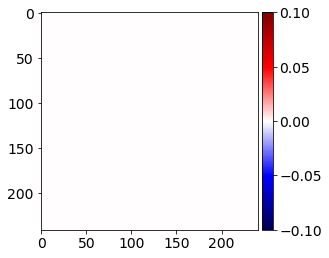

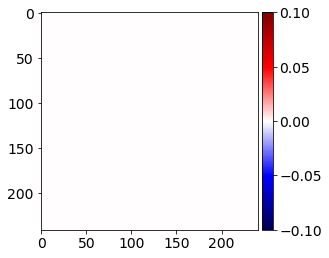

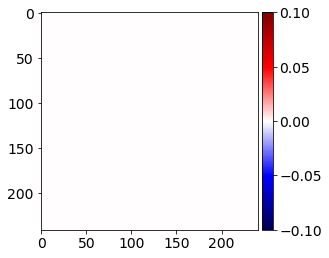

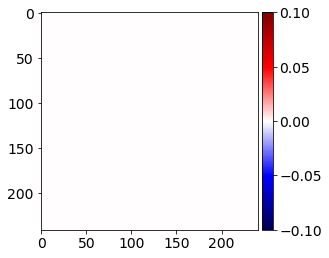

In [14]:
from examples.seismic import plot_image
#NBVAL_SKIP


# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [17]:
assert np.isclose(norm(v[0]), 0.14177763, atol=1e-4, rtol=0)

## Desired Plots for this notebook -- code in rough needs to be added 


### plots for accuracy and correctness

### Testing Scalar Implementation: Compute Norm of Elastic Wave Equation in Vectorial form for Isotropic Media

We use the material from the examples/seismic/acoustic/accuracy.ipynb notebook.

In [17]:
#Reset Fields

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

In [18]:
# Thorbecke's parameter notation

rho = model.rho
cp2 = vp*vp
cs2 = vs*vs

mu = cs2*rho
l = (cp2*rho - 2*mu)


# fdelmodc reference implementation
u_v = Eq(v.forward, v + ts*irho*div(tau))
u_t = Eq(tau.forward, tau + ts * l * diag(div(v.forward)) + ts * mu * (grad(v.forward) + grad(v.forward).T))
stencil = [u_v, u_t]

op2 = Operator(stencil + src_term,  subs=model.spacing_map)

Operator `Kernel` generated in 1.33 s
  * lowering.Clusters: 0.53 s (40.1 %)
  * lowering.Expressions: 0.38 s (28.8 %)
  * lowering.IET: 0.34 s (25.7 %)
Flops reduction after symbolic optimization: [141 --> 73]


In [19]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op2(dt = dt)

Allocating memory for t_xx(2, 245, 245, 245)
Allocating memory for t_xy(2, 245, 245, 245)
Allocating memory for t_xz(2, 245, 245, 245)
Allocating memory for t_yy(2, 245, 245, 245)
Allocating memory for t_yz(2, 245, 245, 245)
Allocating memory for t_zz(2, 245, 245, 245)
Allocating memory for v_x(2, 245, 245, 245)
Allocating memory for v_y(2, 245, 245, 245)
Allocating memory for v_z(2, 245, 245, 245)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/67b05f72a446d106832c52489fba7dce79e3bbbd.c` in 0.21 s from jit-cache
Operator `Kernel` run in 59.59 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<258,30,241,8,241>,<258,30,241,8,241>,<258,30,241,8,241>,<258,30,30,8,8,241>> with OI=0.61 computed in 59.59 s [4.43 GFlops/s, 0.55 GPts/s]
  * section1<<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=59.589363, gflopss=4.424100162205124, gpointss=0.5454370062992618, oi=0.605415002783129, ops=73, itershapes=((258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 30, 8, 8, 241)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.0003170000000000008, gflopss=0.354037854889589, gpointss=0.01953312302839112, oi=21.75, ops=435, itershapes=((258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1))))])

In [21]:
norm_elastic = norm(v[0])
print("Normalized Velocity:", norm_elastic)

Normalized Velocity: 0.17964257


### Testing Scalar Implementation: Reduce $C_{VTI}$ to $C_{ISO}$ 

In order to test that the Scale PDE Implementation is correct, the stress tensor for VTI media can be made isotropic and should retrieve Elastic wave equations for Isotropic media. The results generated from the converted VTI stress tensor should reproduce equivalent results as a purely Isotropic elastic problem. The elastic test case should have an identical problem setup as the elastic VTI case i.e. equivalent grid setup, model, sources etc. This test will be used to verify that the Scalar PDE Implementation of 3D Elastic VTI wave-equations is correct.


Elastic Coefficient Matrix for VTI Media [2]:

$C_{VTI} = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $
Where the compenents are stiffness coefficients as explained previously. 

For Isotropic media, Elastic Coefficient Matrix reduces to [3]:

$ C_{ISO} = \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix} \\ $

where $\lambda$ and $\mu$ are Lamé parameters.


### Make the stress tensor for VTI media isotropic:

By comparing both the matrices above, it is convenient to express the stiffness coefficients for VTI media in terms of generalized Lamé parameters:

$
\begin{aligned}
c_{11} &= \lambda + 2\mu \\
c_{33} &= \lambda + 2\mu \\
c_{44} &= \mu \\
c_{66} &= \mu \\
c_{13} &= \lambda \\
c_{11} - 2c_{66} &= \lambda \\ 
\end{aligned}
$


Hence:

$
\begin{aligned}
c_{11} &= c_{33} \\
c_{44} &= c_{66} \\
c_{13} &= c_{11} - 2c_{66} \\
\end{aligned}
$

This should cancel out all the anisotropy parameters and therefore make the Elastic VTI stress tensor isotropic


In [22]:
#Reset Fields --needs to be fixed
def reset_fields(model, so=so, to=to): ## doesntwork yet
    #Velocity
    v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)
    #Stress
    tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

    return v, tau

#reset_fields(model)

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

In [23]:
# Setup VTI Stress tensor for Isotropic media
c11 = c33
c44 = c66
c13 = c11 - 2*c66

In [24]:
# Particle Velocity for each direction
u_vx = Eq(v[0].forward, v[0] + ts*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, v[1] + ts*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, v[2] + ts*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, tau[0,0] + ts*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, tau[1,1] + ts*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, tau[2,2] + ts*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, tau[0,2] + ts*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, tau[1,2] + ts*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, tau[0,1] + ts*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

#Assemble the operator 
op3 = Operator(stencil + src_term, subs=model.spacing_map)

Operator `Kernel` generated in 1.35 s
  * lowering.Clusters: 0.53 s (39.5 %)
  * lowering.Expressions: 0.40 s (29.9 %)
  * lowering.IET: 0.34 s (25.4 %)
Flops reduction after symbolic optimization: [137 --> 79]


In [25]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op3 (dt=dt)

Allocating memory for t_xx(2, 245, 245, 245)
Allocating memory for t_xy(2, 245, 245, 245)
Allocating memory for t_xz(2, 245, 245, 245)
Allocating memory for t_yy(2, 245, 245, 245)
Allocating memory for t_yz(2, 245, 245, 245)
Allocating memory for t_zz(2, 245, 245, 245)
Allocating memory for v_x(2, 245, 245, 245)
Allocating memory for v_y(2, 245, 245, 245)
Allocating memory for v_z(2, 245, 245, 245)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/924aa7173ebf83c85d186c71ddfca849f363e4c0.c` in 0.27 s from jit-cache
Operator `Kernel` run in 56.04 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<258,30,241,8,241>,<258,30,241,8,241>,<258,30,241,8,241>,<258,30,30,8,8,241>> with OI=0.66 computed in 56.04 s [5.10 GFlops/s, 0.59 GPts/s]
  * section1<<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,<258,1>,

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=56.03498900000002, gflopss=5.091416597262113, gpointss=0.5800348022197344, oi=0.6551751399981807, ops=79, itershapes=((258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 241, 8, 241), (258, 30, 30, 8, 8, 241)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.00035400000000000064, gflopss=0.31703389830508416, gpointss=0.017491525423728782, oi=21.75, ops=435, itershapes=((258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1), (258, 1))))])

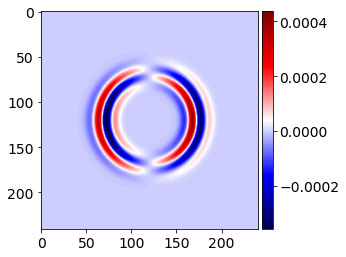

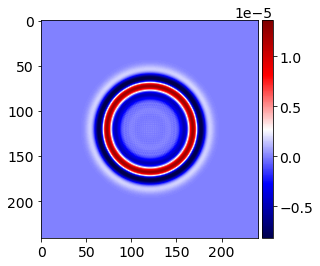

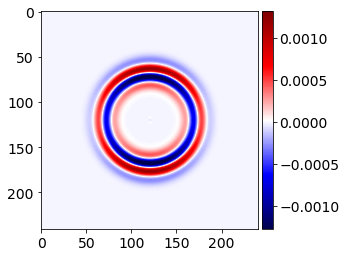

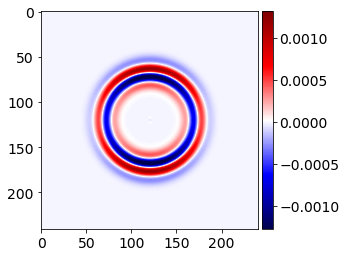

In [26]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [27]:
assert np.isclose(norm(v[0]), norm_elastic, atol=1e-4, rtol=0)

# Verification

Compute the error between numerical and reference solutions for increasing spatial discretization order and grid spacing. Additionally compare the time to solution with the error for these src_coords. from accuracy.ipynb

In [53]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# References

[1] Xu, S. and Liu, Y., 2019. Modeling 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme. Journal of Applied Geophysics, 170, p.103847.

[2] Wang, Y., Mu, P., Duan, Y. and Wang, T., 2018. Numerical Simulation of Elastic Wave Equation and Analysis of Wave Field Characteristics in 2-D VTI Medium. Open Journal of Yangtze Oil and Gas, 3(03), p.153.

[3] Bloot, R., Schleicher, J. and Santos, L.T., 2013. On the elastic wave equation in weakly anisotropic VTI media. Geophysical Journal International, 192(3), pp.1144-1155.